In [46]:
import nltk
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [47]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


In [48]:
sns.set_context('talk')

In [49]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data


# Data

In [51]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
class_corpus = get_corpus_df(CORPUS_PATH)

In [52]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


# Preprocessing

In [53]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [54]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    custom_stop_words = ['movies', 'movie', 'film', 'films', 'scene']
    STOP_WORDS.update(custom_stop_words)
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [55]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [56]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)

    return tokenized_text

In [57]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [58]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [59]:
def get_multi_classification_performance_metrics(X_test, y_test, model, model_name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[::-1]
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text
  sns.set(font_scale = 1.1)

  # Plot Confusion Matrix using Seaborn heatmap()
  # Parameters:
  # first param - confusion matrix in array format
  # annot = True: show the numbers in each heatmap cell
  # fmt = 'd': show numbers as integers.
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Genre", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Action', 'Comedy', 'Horror', 'Sci-Fi'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Genre", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Action', 'Comedy', 'Horror', 'Sci-Fi'][::-1])

  # set plot title
  ax.set_title(f"Confusion Matrix for {model_name}", fontsize=12, pad=20)

  plt.show()
  print('\n')
  print(classification_report(y_test, y_pred))
  print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted')}")
  print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted')}")


def get_binary_classification_performance_metrics(X_test, y_test, model, model_name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[::-1]
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text
  sns.set(font_scale = 1.1)

  # Plot Confusion Matrix using Seaborn heatmap()
  # Parameters:
  # first param - confusion matrix in array format
  # annot = True: show the numbers in each heatmap cell
  # fmt = 'd': show numbers as integers.
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Genre", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Negative', 'Positive'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Genre", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Negative', 'Positive'][::-1])

  # set plot title
  ax.set_title(f"Confusion Matrix for {model_name}", fontsize=14, pad=20)

  plt.show()
  print('\n')
  print(classification_report(y_test, y_pred))
  print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted')}")
  print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted')}")

In [60]:

class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [61]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   normalized_review         200 non-null    object
 10  tokenized_review          200 non-null    object
 11  lemmatized_tokens         200 non-null    object
 12  lemmatized_text           200 non-null    object
dtypes: int64(1), object(12)
memory usage: 21.9+ KB


# Feature Extraction

## Doc2Vec

In [62]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [63]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=100,
                        min_count=1,
                        workers=4)

In [64]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [65]:
features_doc2vec.shape

(200, 100)

# Sentiment Analysis

In [91]:
labels = class_corpus['Review Type (pos or neg)']

In [92]:
labels.value_counts()

Negative    100
Positive    100
Name: Review Type (pos or neg), dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

## Support Vector Machine

As an example, let us train a [support vector machine](https://scikit-learn.org/stable/modules/svm.html) with the default settings.

The best paramaters should of course be estimated through a hyperparameter tuning loop.

In [94]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:

    model_svm = SVC(C=C_value, random_state=10)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.5
C: 0.1, Accuracy: 0.5
C: 1, Accuracy: 0.5
C: 10, Accuracy: 0.48484848484848486
C: 100, Accuracy: 0.48484848484848486
C: 1000, Accuracy: 0.5151515151515151
C: 10000, Accuracy: 0.5303030303030303


The best accuracy is when `C = 10000`.


In [95]:
model_svm = SVC(C=10000, random_state=10)
model_svm.fit(X_train, y_train)

SVC(C=10000, random_state=10)

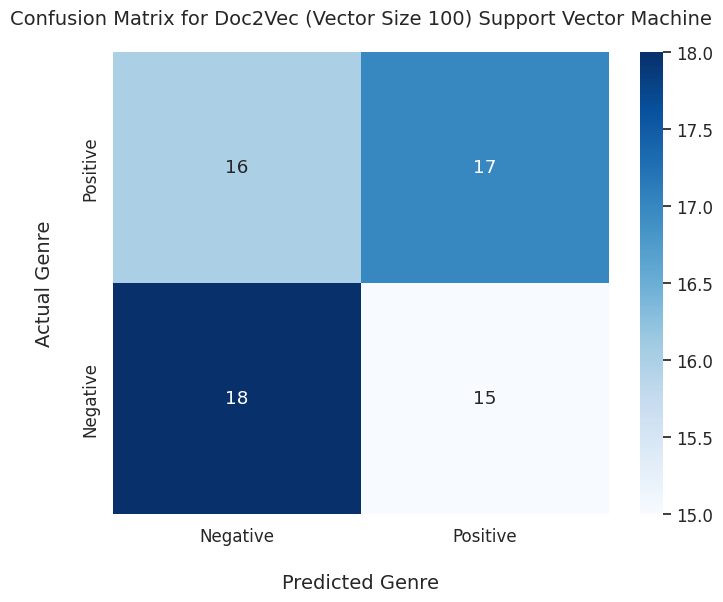



              precision    recall  f1-score   support

    Negative       0.53      0.55      0.54        33
    Positive       0.53      0.52      0.52        33

    accuracy                           0.53        66
   macro avg       0.53      0.53      0.53        66
weighted avg       0.53      0.53      0.53        66

Test Accuracy: 0.5303030303030303
Test F1 Score: 0.530195177956372
Test Precision: 0.5303308823529411
Test Recall: 0.5303030303030303


In [96]:
get_binary_classification_performance_metrics(X_test, y_test, model_svm, 'Doc2Vec (Vector Size 100) Support Vector Machine')

## Decision Tree

In [97]:
for max_depth in range(1,10,1):
  model_dtc = DTC(max_depth=max_depth, random_state=10)
  model_dtc.fit(X_train, y_train)
  y_pred = model_dtc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"max_depth: {max_depth}\tAccuracy: {acc}")

max_depth: 1	Accuracy: 0.4696969696969697
max_depth: 2	Accuracy: 0.45454545454545453
max_depth: 3	Accuracy: 0.42424242424242425
max_depth: 4	Accuracy: 0.48484848484848486
max_depth: 5	Accuracy: 0.42424242424242425
max_depth: 6	Accuracy: 0.42424242424242425
max_depth: 7	Accuracy: 0.42424242424242425
max_depth: 8	Accuracy: 0.42424242424242425
max_depth: 9	Accuracy: 0.4090909090909091


In [98]:
model_dtc = DTC(max_depth=4, random_state=10)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=10)

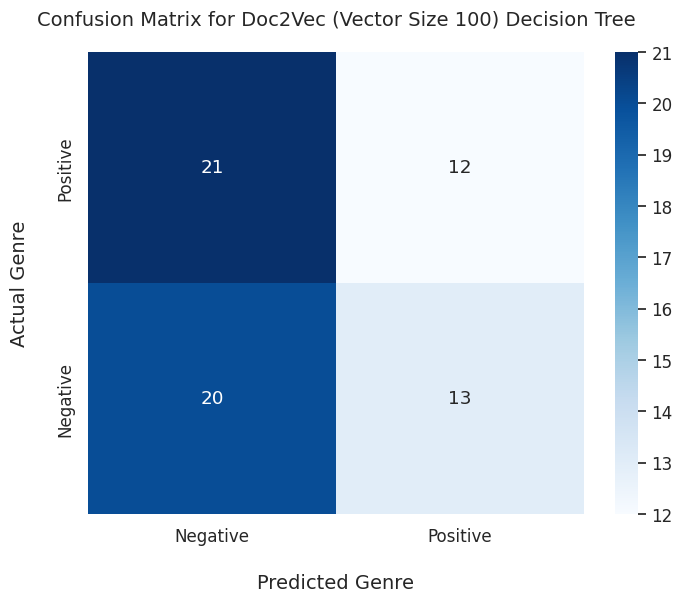



              precision    recall  f1-score   support

    Negative       0.49      0.61      0.54        33
    Positive       0.48      0.36      0.41        33

    accuracy                           0.48        66
   macro avg       0.48      0.48      0.48        66
weighted avg       0.48      0.48      0.48        66

Test Accuracy: 0.48484848484848486
Test F1 Score: 0.4771668219944082
Test Precision: 0.48390243902439023
Test Recall: 0.48484848484848486


In [99]:
get_binary_classification_performance_metrics(X_test, y_test, model_dtc, 'Doc2Vec (Vector Size 100) Decision Tree')

# Random Forest

In [100]:
for n_estimator in range(10, 301, 10):
  model_rf = RFC(n_estimators=n_estimator, random_state=10)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"n_estimator: {n_estimator}\tAccuracy: {acc}")

n_estimator: 10	Accuracy: 0.6060606060606061
n_estimator: 20	Accuracy: 0.5303030303030303
n_estimator: 30	Accuracy: 0.5454545454545454
n_estimator: 40	Accuracy: 0.5151515151515151
n_estimator: 50	Accuracy: 0.5
n_estimator: 60	Accuracy: 0.5303030303030303
n_estimator: 70	Accuracy: 0.48484848484848486
n_estimator: 80	Accuracy: 0.5
n_estimator: 90	Accuracy: 0.5151515151515151
n_estimator: 100	Accuracy: 0.5
n_estimator: 110	Accuracy: 0.5151515151515151
n_estimator: 120	Accuracy: 0.5303030303030303
n_estimator: 130	Accuracy: 0.5151515151515151
n_estimator: 140	Accuracy: 0.5151515151515151
n_estimator: 150	Accuracy: 0.5
n_estimator: 160	Accuracy: 0.5303030303030303
n_estimator: 170	Accuracy: 0.5303030303030303
n_estimator: 180	Accuracy: 0.5
n_estimator: 190	Accuracy: 0.5151515151515151
n_estimator: 200	Accuracy: 0.5151515151515151
n_estimator: 210	Accuracy: 0.5151515151515151
n_estimator: 220	Accuracy: 0.5151515151515151
n_estimator: 230	Accuracy: 0.5151515151515151
n_estimator: 240	Accuracy

In [101]:
model_rf = RFC(n_estimators=10, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=10)

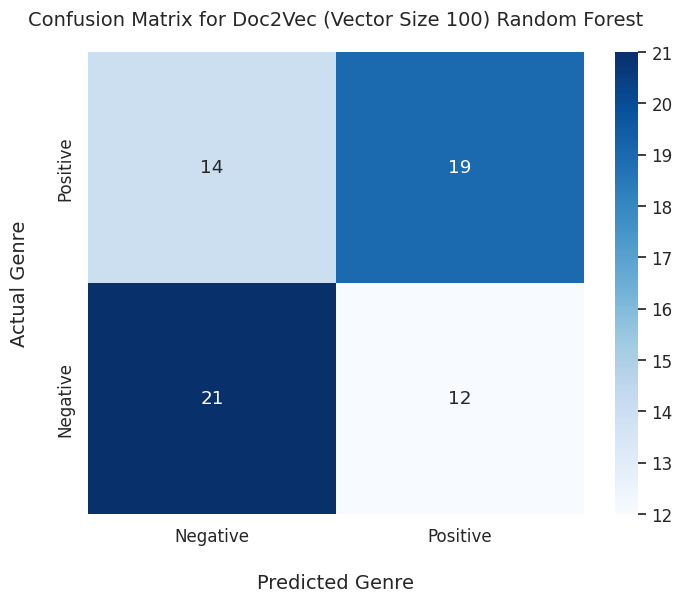



              precision    recall  f1-score   support

    Negative       0.60      0.64      0.62        33
    Positive       0.61      0.58      0.59        33

    accuracy                           0.61        66
   macro avg       0.61      0.61      0.61        66
weighted avg       0.61      0.61      0.61        66

Test Accuracy: 0.6060606060606061
Test F1 Score: 0.6056985294117646
Test Precision: 0.6064516129032259
Test Recall: 0.6060606060606061


In [102]:
get_binary_classification_performance_metrics(X_test, y_test, model_rf, 'Doc2Vec (Vector Size 100) Random Forest')

# Multi-class Classification

In [103]:
labels = class_corpus['Genre of Movie']

In [104]:
labels.value_counts()

Action    50
Comedy    50
Horror    50
Sci-Fi    50
Name: Genre of Movie, dtype: int64

In [105]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [106]:
y_test.value_counts()

Horror    17
Action    17
Comedy    16
Sci-Fi    16
Name: Genre of Movie, dtype: int64

## Support Vector Machine

In [107]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model_svm = SVC(C=C_value, random_state=10)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.21212121212121213
C: 0.1, Accuracy: 0.21212121212121213
C: 1, Accuracy: 0.22727272727272727
C: 10, Accuracy: 0.24242424242424243
C: 100, Accuracy: 0.2727272727272727
C: 1000, Accuracy: 0.803030303030303
C: 10000, Accuracy: 0.8787878787878788


In [108]:
model_svm = SVC(C=10000, random_state=10)
model_svm.fit(X_train, y_train)

SVC(C=10000, random_state=10)

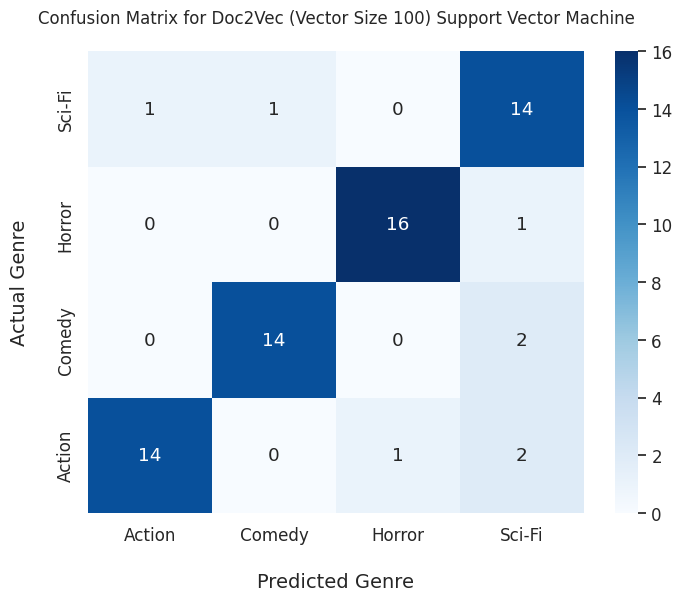



              precision    recall  f1-score   support

      Action       0.93      0.82      0.87        17
      Comedy       0.93      0.88      0.90        16
      Horror       0.94      0.94      0.94        17
      Sci-Fi       0.74      0.88      0.80        16

    accuracy                           0.88        66
   macro avg       0.89      0.88      0.88        66
weighted avg       0.89      0.88      0.88        66

Test Accuracy: 0.8787878787878788
Test F1 Score: 0.8807062561094819
Test Precision: 0.887719298245614
Test Recall: 0.8787878787878788


In [109]:
get_multi_classification_performance_metrics(X_test, y_test, model_svm, 'Doc2Vec (Vector Size 100) Support Vector Machine')

## Decision Tree

In [110]:
for max_depth in range(1,1000,50):
  model_dtc = DTC(max_depth=max_depth, random_state=10)
  model_dtc.fit(X_train, y_train)
  y_pred = model_dtc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"max_depth: {max_depth}\tAccuracy: {acc}")

max_depth: 1	Accuracy: 0.3484848484848485
max_depth: 51	Accuracy: 0.4696969696969697
max_depth: 101	Accuracy: 0.4696969696969697
max_depth: 151	Accuracy: 0.4696969696969697
max_depth: 201	Accuracy: 0.4696969696969697
max_depth: 251	Accuracy: 0.4696969696969697
max_depth: 301	Accuracy: 0.4696969696969697
max_depth: 351	Accuracy: 0.4696969696969697
max_depth: 401	Accuracy: 0.4696969696969697
max_depth: 451	Accuracy: 0.4696969696969697
max_depth: 501	Accuracy: 0.4696969696969697
max_depth: 551	Accuracy: 0.4696969696969697
max_depth: 601	Accuracy: 0.4696969696969697
max_depth: 651	Accuracy: 0.4696969696969697
max_depth: 701	Accuracy: 0.4696969696969697
max_depth: 751	Accuracy: 0.4696969696969697
max_depth: 801	Accuracy: 0.4696969696969697
max_depth: 851	Accuracy: 0.4696969696969697
max_depth: 901	Accuracy: 0.4696969696969697
max_depth: 951	Accuracy: 0.4696969696969697


In [111]:
model_dtc = DTC(max_depth=50, random_state=10)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, random_state=10)

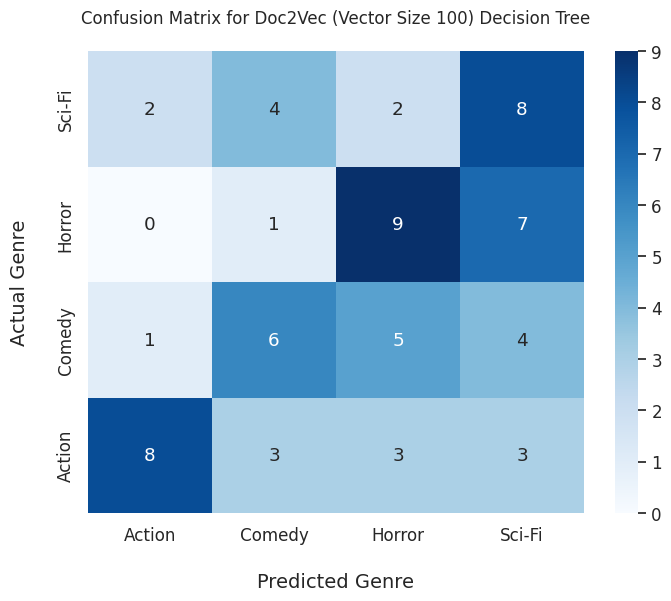



              precision    recall  f1-score   support

      Action       0.73      0.47      0.57        17
      Comedy       0.43      0.38      0.40        16
      Horror       0.47      0.53      0.50        17
      Sci-Fi       0.36      0.50      0.42        16

    accuracy                           0.47        66
   macro avg       0.50      0.47      0.47        66
weighted avg       0.50      0.47      0.48        66

Test Accuracy: 0.4696969696969697
Test F1 Score: 0.4750170881749829
Test Precision: 0.5013877669380062
Test Recall: 0.4696969696969697


In [112]:
get_multi_classification_performance_metrics(X_test, y_test, model_dtc, 'Doc2Vec (Vector Size 100) Decision Tree')

## Random Forest

In [113]:
for n_estimator in range(1, 1000, 50):
  model_rf = RFC(n_estimators=n_estimator, random_state=10)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"n_estimator: {n_estimator}\tAccuracy: {acc}")

n_estimator: 1	Accuracy: 0.3939393939393939
n_estimator: 51	Accuracy: 0.5909090909090909
n_estimator: 101	Accuracy: 0.6060606060606061
n_estimator: 151	Accuracy: 0.5909090909090909
n_estimator: 201	Accuracy: 0.5909090909090909
n_estimator: 251	Accuracy: 0.5757575757575758
n_estimator: 301	Accuracy: 0.5757575757575758
n_estimator: 351	Accuracy: 0.5757575757575758
n_estimator: 401	Accuracy: 0.5757575757575758
n_estimator: 451	Accuracy: 0.5757575757575758
n_estimator: 501	Accuracy: 0.5909090909090909
n_estimator: 551	Accuracy: 0.5757575757575758
n_estimator: 601	Accuracy: 0.5757575757575758
n_estimator: 651	Accuracy: 0.5757575757575758
n_estimator: 701	Accuracy: 0.5757575757575758
n_estimator: 751	Accuracy: 0.5757575757575758
n_estimator: 801	Accuracy: 0.5757575757575758
n_estimator: 851	Accuracy: 0.5757575757575758
n_estimator: 901	Accuracy: 0.5757575757575758
n_estimator: 951	Accuracy: 0.5757575757575758


In [116]:
model_rf = RFC(n_estimators=100, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

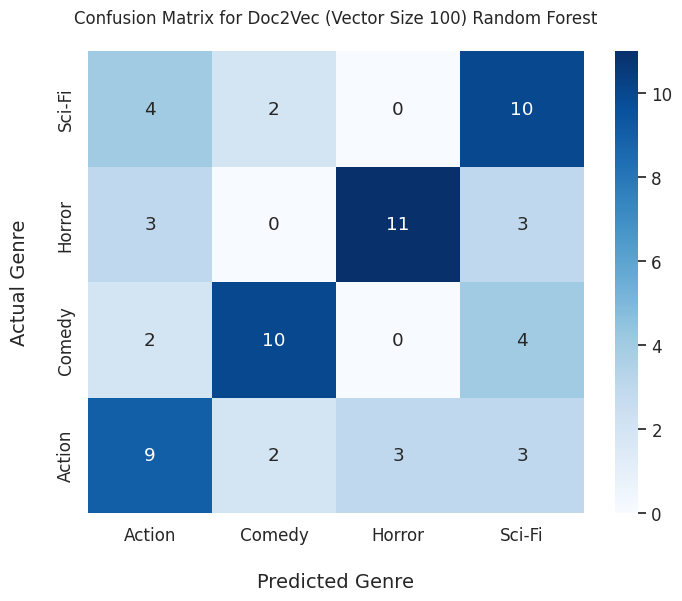



              precision    recall  f1-score   support

      Action       0.50      0.53      0.51        17
      Comedy       0.71      0.62      0.67        16
      Horror       0.79      0.65      0.71        17
      Sci-Fi       0.50      0.62      0.56        16

    accuracy                           0.61        66
   macro avg       0.62      0.61      0.61        66
weighted avg       0.63      0.61      0.61        66

Test Accuracy: 0.6060606060606061
Test F1 Score: 0.61155952768856
Test Precision: 0.6255411255411256
Test Recall: 0.6060606060606061


In [117]:
get_multi_classification_performance_metrics(X_test, y_test, model_rf, 'Doc2Vec (Vector Size 100) Random Forest')

# Conclusion

When text is an input to a supervised learning task (e.g., sentiment analysis or multi-class prediction) detailed examination of the classification metrics helps select the appropriate feature engineering process.